In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import seaborn as sns
from datetime import datetime
import talib
#import yfinance as yf
#df = yf.download('ETH-USD', start = '2014-01-01')
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
sns.set()
#import pylab
import scipy.stats

In [2]:
sns.set_style('whitegrid')
idx = pd.IndexSlice
deciles = np.arange(.1, 1, .1).round(1)

In [3]:
filename= 'stock_prices.h5'

In [4]:
with pd.HDFStore(filename) as store:
    data = (store['us_stocks']
            .loc[idx[:, '2006':'2016'], :]  
            .unstack('ticker')
            .sort_index() 
            .fillna(method='ffill', limit=5) 
            .stack('ticker')
            .swaplevel()     
            .dropna()       
            .sort_index())

In [5]:
daily_returns = data.groupby('ticker').close.pct_change() # returns computed based on closing prices

In [6]:
daily_returns.describe(percentiles=[.00001, .0001, .001, .999, .9999, .99999]).iloc[1:]

mean         0.000776
std          0.138084
min         -0.993615
0.001%      -0.706667
0.01%       -0.393309
0.1%        -0.191152
50%          0.000000
99.9%        0.230661
99.99%       0.580756
99.999%      1.783016
max        283.000000
Name: close, dtype: float64

In [7]:
outliers = daily_returns[(daily_returns < daily_returns.quantile(.00001)) |
                         (daily_returns > daily_returns.quantile(.99999))]

In [8]:
print(f'# Observations: {len(outliers):,.0f} | # Tickers: {len(outliers.index.unique("ticker")):,.0f}')

# Observations: 155 | # Tickers: 92


In [9]:
data = data.drop(outliers.index.unique('ticker'), level='ticker')

In [10]:
dv = data.close.mul(data.volume)

In [11]:
top500 = (dv.groupby(level='date')
          .rank(ascending=False)
          .unstack('ticker')
          .dropna(thresh=8*252, axis=1)
          .mean()
          .nsmallest(500))

In [12]:
data = data.drop(data.index.unique('ticker').difference(top500.index), level='ticker')

In [13]:
tickers = data.index.unique('ticker')
print(f"# Tickers: {len(tickers):,.0f} | # Dates: {len(data.index.unique('date')):,.0f}")

# Tickers: 500 | # Dates: 2,845


## Compute returns

In [14]:
by_ticker = data.groupby(level='ticker')

In [15]:
T = [1, 3, 5, 10, 21, 42, 63, 126, 252]

In [16]:
for t in T:
    data[f'ret_{t:02}'] = by_ticker.close.pct_change(t) # compute returns for each ticker and period

In [17]:
ticker = 'AMZN'
price_sample = data.loc[idx[ticker, :], :].reset_index('ticker', drop=True)

<AxesSubplot:xlabel='date'>

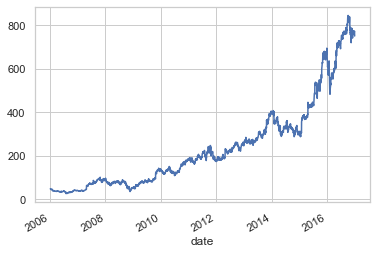

In [18]:
price_sample.close.plot()

<AxesSubplot:xlabel='date'>

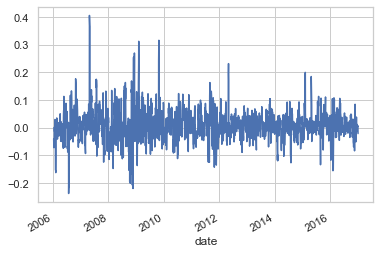

In [19]:
price_sample.ret_05.plot()

In [20]:
df = price_sample.loc['2012', ['close']]

In [21]:
s = talib.BBANDS(df.close,   # Number of periods (2 to 100000)
                 timeperiod=20,
                 nbdevup=2,    # Deviation multiplier for lower band
                 nbdevdn=2,    # Deviation multiplier for upper band
                 matype=1      # default: SMA
                 )

In [22]:
bb_bands = ['upper', 'middle', 'lower']

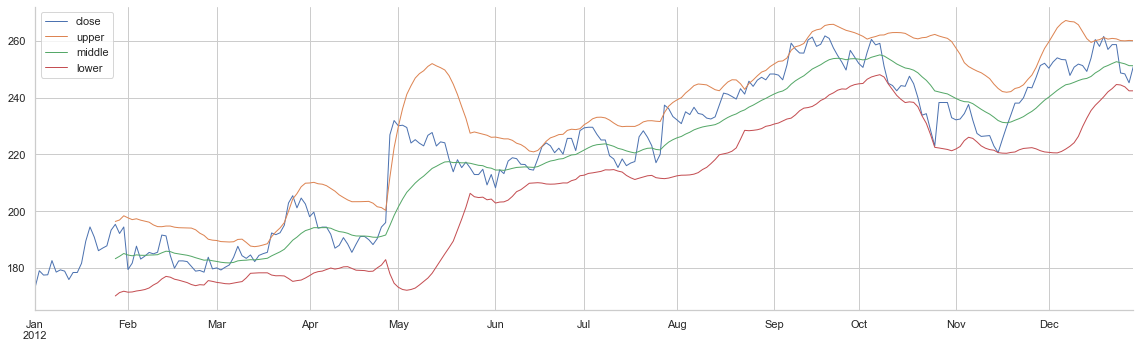

In [23]:
df = df.assign(**dict(zip(bb_bands, s)))
ax = df.loc[:, ['close'] + bb_bands].plot(figsize=(16, 5), lw=1)

ax.set_xlabel('')
sns.despine()
plt.tight_layout();

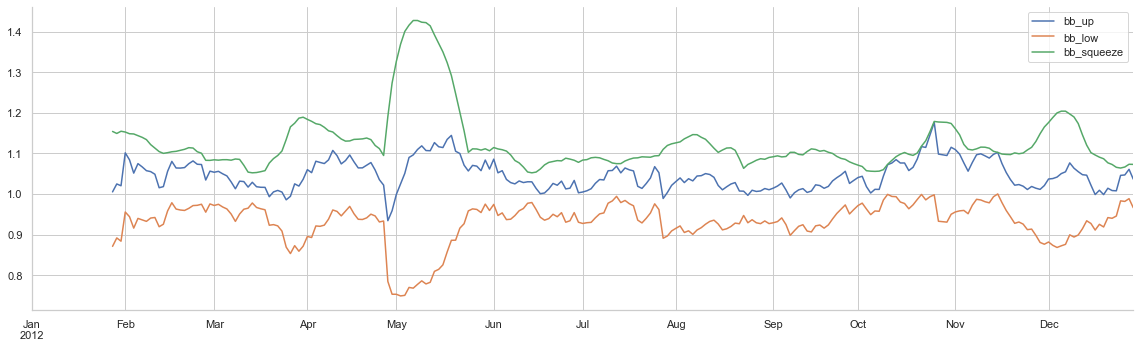

In [24]:
fig, ax = plt.subplots(figsize=(16,5))
df.upper.div(df.close).plot(ax=ax, label='bb_up')
df.lower.div(df.close).plot(ax=ax, label='bb_low')
df.upper.div(df.lower).plot(ax=ax, label='bb_squeeze', rot=0)

plt.legend()
ax.set_xlabel('')
sns.despine()
plt.tight_layout();

## Momentum Indicators

### Average Directional Movement Index (ADX)

In [31]:
df = price_sample.loc[:, ['high', 'low', 'close']]

In [32]:
df['ADX'] = talib.ADX(df.high, 
                      df.low, 
                      df.close, 
                      timeperiod=14)

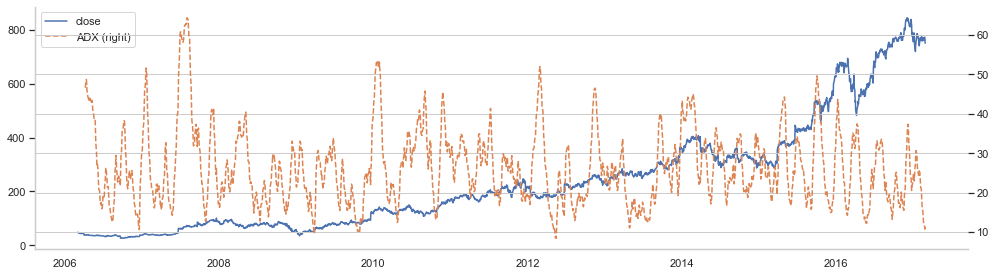

In [33]:
ax = df[['close', 'ADX']].plot(figsize=(14, 4), secondary_y='ADX', style=['-', '--'], rot=0)
ax.set_xlabel('')
sns.despine()
plt.tight_layout();

### Balance Of Power (BOP)

In [34]:
df = price_sample.loc['2013', ['open', 'high', 'low', 'close']]

In [35]:
df['BOP'] = talib.BOP(open=df.open,
                      high=df.high,
                      low=df.low,
                      close=df.close)

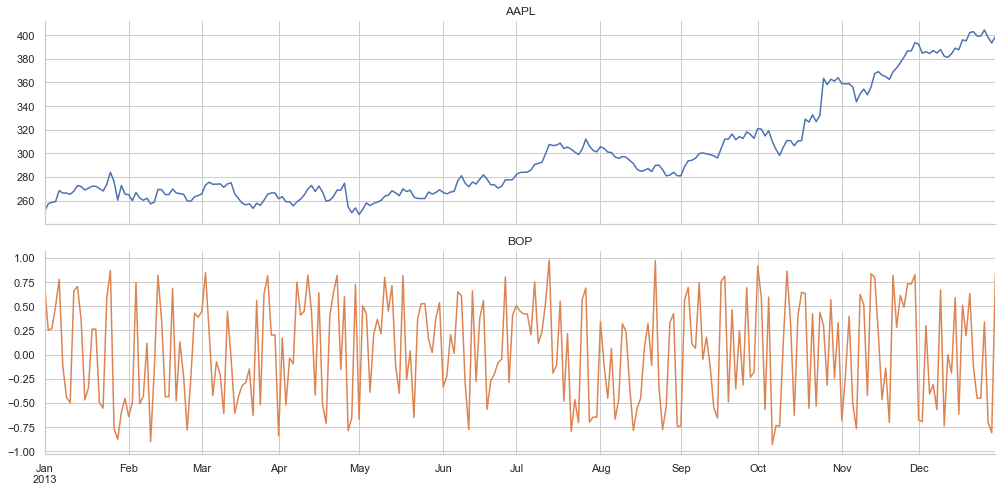

In [36]:
axes = df[['close', 'BOP']].plot(figsize=(14, 7), rot=0, subplots=True, title=['AAPL', 'BOP'], legend=False)
axes[1].set_xlabel('')
sns.despine()
plt.tight_layout();

### Moving Average Convergence/Divergence (MACD)

In [37]:
df = price_sample.loc['2013', ['close']]

In [38]:
macd, macdsignal, macdhist = talib.MACD(df.close,
                                        fastperiod=12,
                                        slowperiod=26,
                                        signalperiod=9)
df['MACD'] = macd
df['MACDSIG'] = macdsignal
df['MACDHIST'] = macdhist

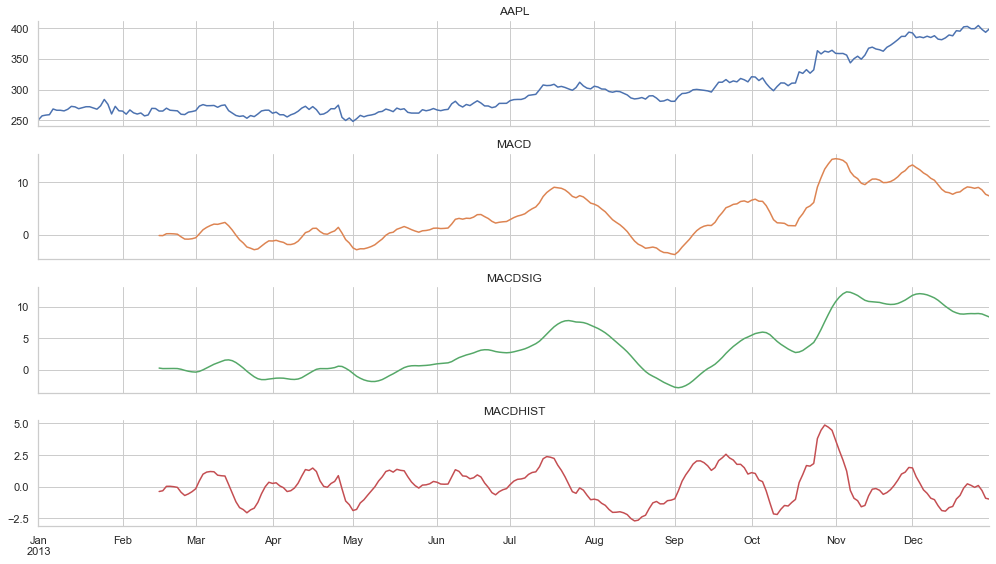

In [39]:
axes = df.plot(figsize=(14, 8),
               rot=0,
               subplots=True,
               title=['AAPL', 'MACD', 'MACDSIG', 'MACDHIST'],
               legend=False)

axes[-1].set_xlabel('')
sns.despine()
plt.tight_layout()

### Money Flow Index

In [40]:
df = price_sample.loc['2013', ['high', 'low', 'close', 'volume']]

In [41]:
df['MFI'] = talib.MFI(df.high, 
                      df.low, 
                      df.close, 
                      df.volume, 
                      timeperiod=14)

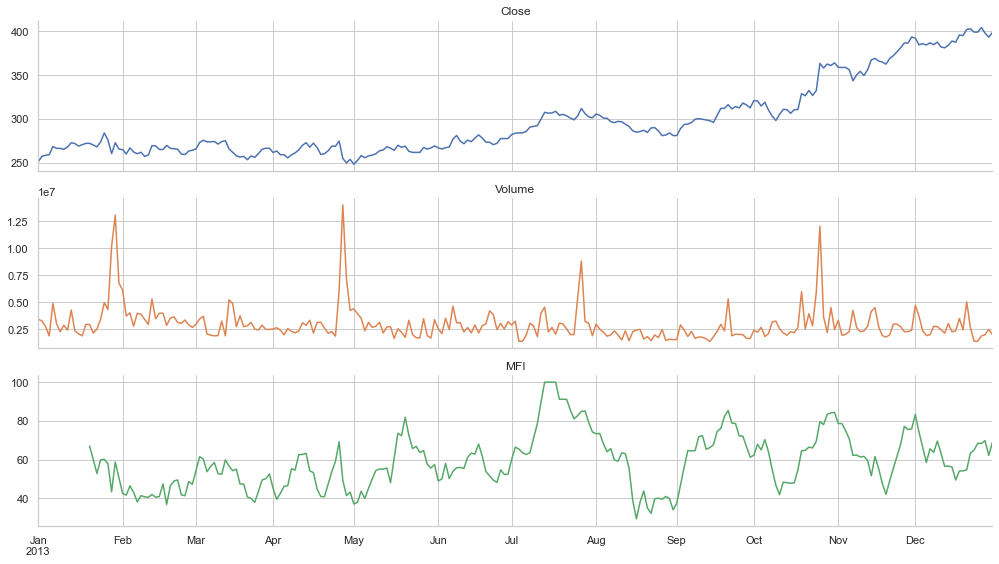

In [42]:
axes = df[['close', 'volume', 'MFI']].plot(figsize=(14, 8),
                                           rot=0,
                                           subplots=True,
                                           title=['Close', 'Volume', 'MFI'],
                                           legend=False)
axes[-1].set_xlabel('')
sns.despine()
plt.tight_layout()

### Relative Strength Index

In [43]:
df = price_sample.loc['2013', ['close']]

In [44]:
df['RSI'] = talib.RSI(df.close, timeperiod=14)

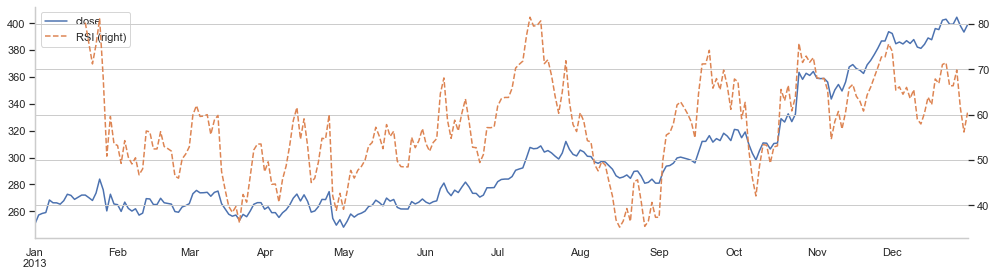

In [45]:
ax = df.plot(figsize=(14, 4), rot=0, secondary_y=['RSI'], style=['-', '--'])
ax.set_xlabel('')
sns.despine()
plt.tight_layout()

### On Balance Volume (OBV)

In [46]:
df = price_sample.loc['2013', ['close', 'volume']]

In [47]:
df['OBV'] = talib.OBV(df.close,
                      df.volume)

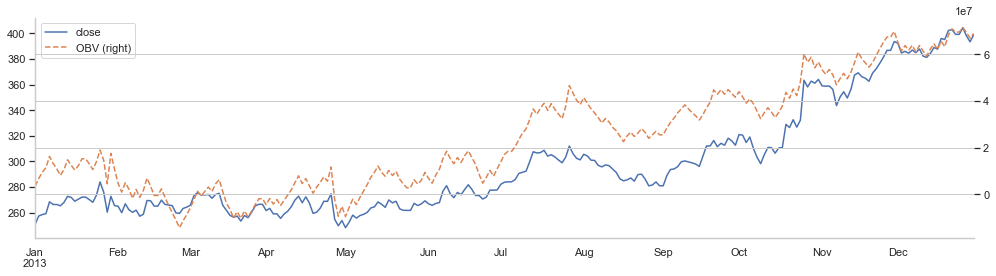

In [48]:
ax = df[['close', 'OBV']].plot(figsize=(14, 4),
                               rot=0,
                               secondary_y='OBV', style=['-', '--'])
ax.set_xlabel('')
sns.despine()
plt.tight_layout()

### NATR

In [161]:
df = price_sample.loc['2013', ['high', 'low', 'close']]

In [162]:
df['NATR'] = talib.NATR(df.high,
                        df.low,
                        df.close,
                        timeperiod=14)

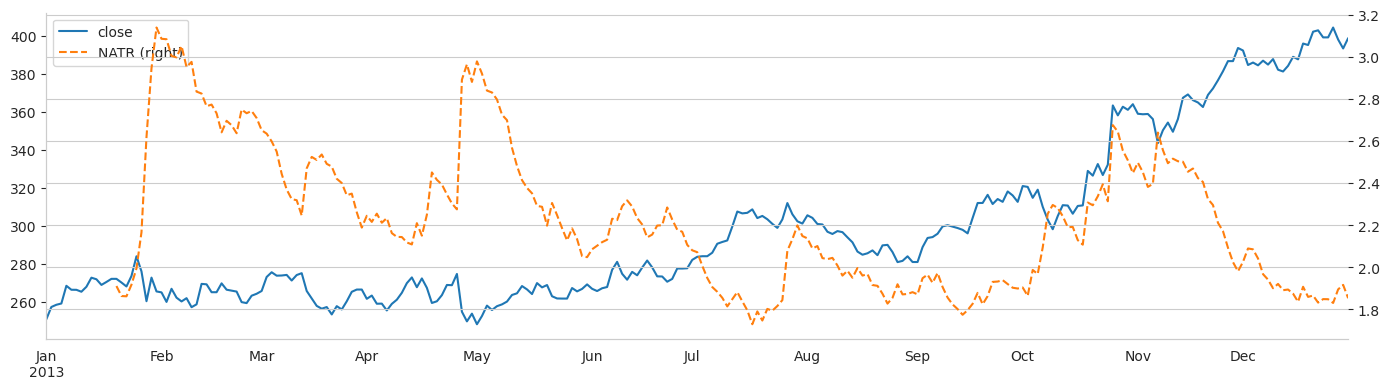

In [163]:
ax = df[['close', 'NATR']].plot(figsize=(14, 4),
                           rot=0,
                           secondary_y='NATR', style=['-', '--'])

ax.set_xlabel('')
sns.despine()
plt.tight_layout()